In [1]:
# DATA_PATH = '../input/'
DATA_PATH = '../input/shopee-product-matching/'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2, matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import gc

In [3]:
COMPUTE_CV = True

test = pd.read_csv(DATA_PATH + 'test.csv')
if len(test)>3: COMPUTE_CV = False
else: print('this submission notebook will compute CV score, but commit notebook will not')

# COMPUTE_CV = False

if COMPUTE_CV:
    train = pd.read_csv(DATA_PATH + 'train.csv')
    train['image'] = DATA_PATH + 'train_images/' + train['image']
    tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
    train['target'] = train.label_group.map(tmp)
#     train_gf = cudf.read_csv(DATA_PATH + 'train.csv')
else:
    train = pd.read_csv(DATA_PATH + 'test.csv')
    train['image'] = DATA_PATH + 'test_images/' + train['image']
#     train_gf = cudf.read_csv(DATA_PATH + 'test.csv')
    
print('train shape is', train.shape )
train.head()

this submission notebook will compute CV score, but commit notebook will not
train shape is (34250, 6)


,posting_id,image,image_phash,title,label_group,target
0,train_129225211,../input/shopee-product-matching/train_images/...,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,../input/shopee-product-matching/train_images/...,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,../input/shopee-product-matching/train_images/...,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,../input/shopee-product-matching/train_images/...,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,../input/shopee-product-matching/train_images/...,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


# Image Augmentation

图像数据扩增

https://github.com/albumentations-team/albumentations

In [4]:
import albumentations as A

def visualize(image):
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(image)

OpenCV reads an image in BGR format (so color channels of the image have the following order: Blue, Green, Red). Albumentations uses the most common and popular RGB image format. So when using OpenCV, we need to convert the image format to RGB explicitly.

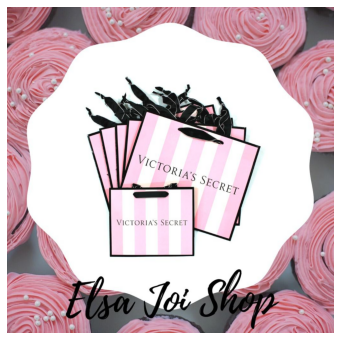

In [5]:
image = cv2.imread(train['image'].iloc[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

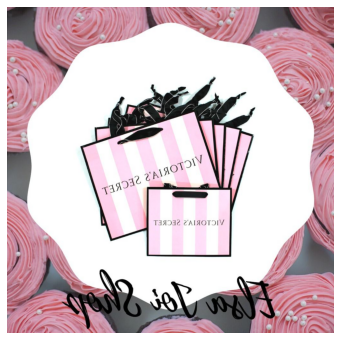

In [6]:
transform = A.HorizontalFlip(p=1)
augmented_image = transform(image=image)['image']
visualize(augmented_image)

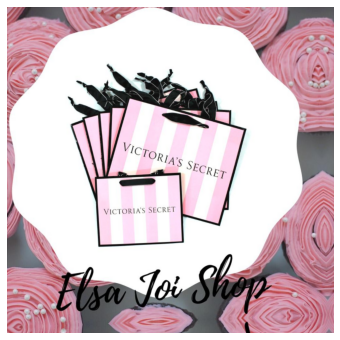

In [7]:
transform = A.ShiftScaleRotate(p=1)
augmented_image = transform(image=image)['image']
visualize(augmented_image)

Define an augmentation pipeline using Compose, pass the image to it and receive the augmented image

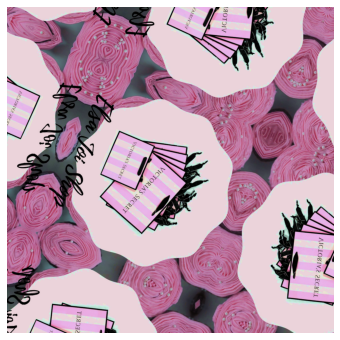

In [8]:
transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
])
augmented_image = transform(image=image)['image']
visualize(augmented_image)

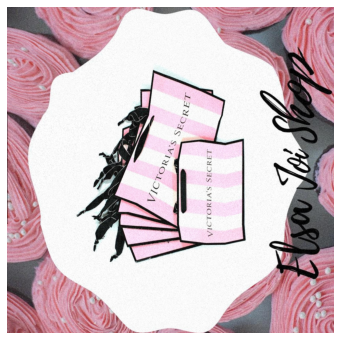

In [9]:
transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])
augmented_image = transform(image=image)['image']
visualize(augmented_image)

# Text Augmentation


In [11]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

## Swap character randomly¶


In [12]:
aug = nac.RandomCharAug(action="swap")

In [13]:
texts = train['title'].iloc[:10]

for text in texts:
    augmented_text = aug.augment(text)
    
    print('-'*20)
    print('Original Input:{}'.format(text))
    print('Agumented Output:{}'.format(augmented_text))

--------------------
Original Input:Paper Bag Victoria Secret
Agumented Output:Paerp Bag Vctiorai Secret
--------------------
Original Input:Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
Agumented Output:Dolube Ptae 3M VHB 12 mm x 4, 5 m ORIGINAL / DOLUBE OFMA ATEP
--------------------
Original Input:Maling TTS Canned Pork Luncheon Meat 397 gr
Agumented Output:Amlign TTS Cannde Opkr Luncheon Meat 397 gr
--------------------
Original Input:Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
Agumented Output:Asdter Batik Lengan pendek - Motif Acak / Camrpu - Elehr Akncgin (DPT001 - 00) Batik karakter Alhadi
--------------------
Original Input:Nescafe \xc3\x89clair Latte 220ml
Agumented Output:Ensacef \ xc3 \ x89clair Altte 202lm
--------------------
Original Input:CELANA WANITA  (BB 45-84 KG)Harem wanita (bisa cod)
Agumented Output:CELAAN WAINAT (BB 45 - 84 KG) Harem awinta (isba cod )
--------------------
Original Input:Jubah

## Delete character randomly


In [14]:
aug = nac.RandomCharAug(action="delete")

In [15]:
texts = train['title'].iloc[:10]

for text in texts:
    augmented_text = aug.augment(text)
    
    print('-'*20)
    print('Original Input:{}'.format(text))
    print('Agumented Output:{}'.format(augmented_text))

--------------------
Original Input:Paper Bag Victoria Secret
Agumented Output:Pae Bag ictia Secret
--------------------
Original Input:Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
Agumented Output:Doub ae 3M VHB 12 mm x 4, 5 m RIGAL / OUBE OM TAPE
--------------------
Original Input:Maling TTS Canned Pork Luncheon Meat 397 gr
Agumented Output:aing TTS Canned Pk Luhon Meat 397 gr
--------------------
Original Input:Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
Agumented Output:Daster Btk Lengan ende - Mif Acak / Campur - Ler Kancing (DP01 - 00) Batik karakter Alhi
--------------------
Original Input:Nescafe \xc3\x89clair Latte 220ml
Agumented Output:Nescafe \ xc3 \ x89ai Lat 22m
--------------------
Original Input:CELANA WANITA  (BB 45-84 KG)Harem wanita (bisa cod)
Agumented Output:CEAA WANI (BB 45 - 84 KG) Har want (ba cod )
--------------------
Original Input:Jubah anak size 1-12 thn
Agumented Output:Jub nk se 1 - 1


## Word Augmenter

Use of word2vec (Mikolov et al., 2013), GloVe (Pennington et al., 2014), fasttext (Joulin et al., 2016), BERT(Devlin et al., 2018) and wordnet to insert and substitute similar word. Word2vecAug, GloVeAug and FasttextAug use word embeddings to find most similar group of words to replace original word. On the other hand, BertAug use language models to predict possible target word. WordNetAug use statistics way to find the similar group of words.

In [16]:
text = train['title'].iloc[0]

# model_type: word2vec, glove or fasttext
aug = naw.WordEmbsAug(
    model_type='fasttext', model_path='../input/fasttext-wikinews/wiki-news-300d-1M.vec')
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
Paper Bag Victoria Secret
Augmented Text:
Paper Mix-Up Victoria Thousand-Year


In [17]:
for text in train['title'].iloc[:10]:
    augmented_text = aug.augment(text)
    print('-'*20)
    print('Original Input:{}'.format(text))
    print('Agumented Output:{}'.format(augmented_text))

--------------------
Original Input:Paper Bag Victoria Secret
Agumented Output:Review Bag Victoria Quest
--------------------
Original Input:Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
Agumented Output:Sculls WORM IBM VHB 35 mm x 4, 5 m ORIGINAL / DOUBLE MUSIK TAPE
--------------------
Original Input:Maling TTS Canned Pork Luncheon Meat 397 gr
Agumented Output:Pughe TTS Condiment Pork Luncheon Meat 336 gr
--------------------
Original Input:Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
Agumented Output:Daster Batik Lengan terdengar - SunView Acak / Campur - Putul Kancing (DPT001 - 540053) Batik lënë Abdul-Amir
--------------------
Original Input:Nescafe \xc3\x89clair Latte 220ml
Agumented Output:Starbucks \ xc3 \ x89clair lattes 220ml
--------------------
Original Input:CELANA WANITA  (BB 45-84 KG)Harem wanita (bisa cod)
Agumented Output:CELANA WANITA (KN 49 - 84 KG) Eunuchs sikap (mencari cod )
--------------------


## Contextual Word Embeddings Augmenter (BERT)

In [18]:
# Augment French by BERT
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', aug_p=0.1)
text = "Bonjour, J'aimerais une attestation de l'employeur certifiant que je suis en CDI."
augmented_text = aug.augment(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Original:
Bonjour, J'aimerais une attestation de l'employeur certifiant que je suis en CDI.
Augmented Text:
bonjour, j'que une attestation de l'employeur ou que je regard en cdi.


In [19]:
for text in train['title'].iloc[:10]:
    augmented_text = aug.augment(text)
    print('-'*20)
    print('Original Input:{}'.format(text))
    print('Agumented Output:{}'.format(augmented_text))

--------------------
Original Input:Paper Bag Victoria Secret
Agumented Output:paper bag no secret
--------------------
Original Input:Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
Agumented Output:double tape 3m × 12 mm x 4, 5 m original / double foam cell
--------------------
Original Input:Maling TTS Canned Pork Luncheon Meat 397 gr
Agumented Output:maling tts canned burger luncheon in 397 gr
--------------------
Original Input:Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
Agumented Output:daster batik para pendek - dan acak / campur - leher kancing ( dpt001 - 00 ) batik para ।
--------------------
Original Input:Nescafe \xc3\x89clair Latte 220ml
Agumented Output:nescafe \ xc3 \ 0 latte op
--------------------
Original Input:CELANA WANITA  (BB 45-84 KG)Harem wanita (bisa cod)
Agumented Output:celana wanita ( bb 45 - 100 kg ) harem wanita ( bisa 24 )
--------------------
Original Input:Jubah anak size 1-12 thn
Agumen

## TF-IDF Augmenter

In [20]:
import re
import nlpaug.model.word_stats as nmw

def _tokenizer(text, token_pattern=r"(?u)\b\w\w+\b"):
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(text)

# Tokenize input
train_x_tokens = [_tokenizer(x) for x in train['title']]

# Train TF-IDF model
tfidf_model = nmw.TfIdf()
tfidf_model.train(train_x_tokens)
tfidf_model.save('.')

# Load TF-IDF augmenter
aug = naw.TfIdfAug(model_path='.', tokenizer=_tokenizer)

In [21]:
texts = train['title'].iloc[:10]

for text in texts:
    augmented_text = aug.augment(text)
    
    print('-'*20)
    print('Original Input:{}'.format(text))
    print('Agumented Output:{}'.format(augmented_text))

--------------------
Original Input:Paper Bag Victoria Secret
Agumented Output:IRIS Pistol Victoria Secret
--------------------
Original Input:Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
Agumented Output:Double PERABOTAN 3M VHB AMALAGROSIR mm ORIGINAL DOUBLE 3ring TAPE
--------------------
Original Input:Maling TTS Canned Pork Luncheon Meat 397 gr
Agumented Output:Working TTS OMG Pork Luncheon Meat 397 MAMY
--------------------
Original Input:Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
Agumented Output:Kental Batik Lengan PERAK Motif HURUF Campur Leher Kancing DPT001 00 MOIZTURIZING karakter Best
--------------------
Original Input:Nescafe \xc3\x89clair Latte 220ml
Agumented Output:Sorong xc3 x89clair ORY 220ml
--------------------
Original Input:CELANA WANITA  (BB 45-84 KG)Harem wanita (bisa cod)
Agumented Output:CELANA WANITA BB 45 84 KG mym S300 SH1942 cod
--------------------
Original Input:Jubah anak size 1-12

## Contextual Word Embeddings for Sentence Augmenter

In [22]:
# model_path: xlnet-base-cased or gpt2
aug = nas.ContextualWordEmbsForSentenceAug(model_path='xlnet-base-cased')
augmented_texts = aug.augment(text, n=3)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

In [23]:
texts = train['title'].iloc[:10]

for text in texts:
    augmented_text = aug.augment(text)
    
    print('-'*20)
    print('Original Input:{}'.format(text))
    print('Agumented Output:{}'.format(augmented_text))

--------------------
Original Input:Paper Bag Victoria Secret
Agumented Output:Paper Bag Victoria Secret and Paper bags my favourite things to do on Saturday.
--------------------
Original Input:Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE
Agumented Output:Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DOUBLE FOAM TAPE SPACE T-Wall Tape, for your aesthetics as described for that color in orange/white this section is for your purposes you may click this
--------------------
Original Input:Maling TTS Canned Pork Luncheon Meat 397 gr
Agumented Output:Maling TTS Canned Pork Luncheon Meat 397 gr s Meat 453 mm Snus Porsk M4 P4 N7 Sn.
--------------------
Original Input:Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi
Agumented Output:Daster Batik Lengan pendek - Motif Acak / Campur - Leher Kancing (DPT001-00) Batik karakter Alhadi Barak al-T-Hun-Qaws: If the story is like you asked for the price and what do it get the more
------

# Product/Pair Augmentation

we random swap the image and title in same group to get new product.

将商品图像和title，重新组合得到新的商品。

In [24]:
train.head()

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,../input/shopee-product-matching/train_images/...,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,../input/shopee-product-matching/train_images/...,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,../input/shopee-product-matching/train_images/...,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,../input/shopee-product-matching/train_images/...,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,../input/shopee-product-matching/train_images/...,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


In [25]:
train.shape

(34250, 6)

In [26]:
aug_image_title_pairs = []
for df in train.groupby('label_group'):
    for idx1, img in enumerate(df[1]['image']):
        for idx2, title in enumerate(df[1]['title']):
            if idx1 == idx2:
                continue
            
            aug_image_title_pairs.append([img, title])
            
    break

In [27]:
pd.DataFrame(aug_image_title_pairs, columns=['image', 'title'])

,image,title
0,../input/shopee-product-matching/train_images/...,SARUNG CELANA WADIMOR DEWASA HITAM POLOS SARCEL
1,../input/shopee-product-matching/train_images/...,WARNA RANDOM ACAK Sarung Celana Wadimor MURAH ...
2,../input/shopee-product-matching/train_images/...,Sarung celana wadimor original 100% dewasa dan...
3,../input/shopee-product-matching/train_images/...,WARNA RANDOM ACAK Sarung Celana Wadimor MURAH ...
4,../input/shopee-product-matching/train_images/...,Sarung celana wadimor original 100% dewasa dan...
5,../input/shopee-product-matching/train_images/...,SARUNG CELANA WADIMOR DEWASA HITAM POLOS SARCEL


In [28]:
df[1]

,posting_id,image,image_phash,title,label_group,target
3874,train_1646767365,../input/shopee-product-matching/train_images/...,e925873ed09cd08f,Sarung celana wadimor original 100% dewasa dan...,258047,"[train_1646767365, train_398181303, train_1528..."
6738,train_398181303,../input/shopee-product-matching/train_images/...,e9b5833e929e909c,SARUNG CELANA WADIMOR DEWASA HITAM POLOS SARCEL,258047,"[train_1646767365, train_398181303, train_1528..."
31859,train_1528423085,../input/shopee-product-matching/train_images/...,ea97861c926a71e3,WARNA RANDOM ACAK Sarung Celana Wadimor MURAH ...,258047,"[train_1646767365, train_398181303, train_1528..."


we see this group has 3 product, now we get 6 new product!